<a href="https://colab.research.google.com/github/alessiomodonesi/Python-Exercises/blob/main/ai/lab3/Intelligenza_Artificiale_Lab3_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Laboratory Lecture 3**

# Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds):
        self.__dict__.update(initial=initial, goal=goal, **kwds)

    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0

    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)


class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost


failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.


def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)


def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]

# Queues

First-in-first-out and Last-in-first-out queues, and a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [ ]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x):
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

# Search Algorithms: Best-First

Best-first search with various *f(n)* functions gives us different search algorithms. Note that A\*, weighted A\* and greedy search can be given a heuristic function, `h`, but if `h` is not supplied they use the problem's default `h` function (if the problem does not define one, it is taken as *h(n)* = 0).

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def best_first_tree_search(problem, f):
    "A version of best_first_search without the `reached` table."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if not is_cycle(child):
                frontier.add(child)
    return failure


def g(n): return n.path_cost


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))


def astar_tree_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n), with no `reached` table."""
    h = h or problem.h
    return best_first_tree_search(problem, f=lambda n: g(n) + h(n))


def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))


def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))


def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)



# Other Search Algorithms

Here are the other search algorithms:

In [ ]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result


def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result


def depth_first_recursive_search(problem, node=None):
    if node is None:
        node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    elif is_cycle(node):
        return failure
    else:
        for child in expand(problem, node):
            result = depth_first_recursive_search(problem, child)
            if result:
                return result
        return failure

# Problem Domains

Now we turn our attention to defining some problem domains as subclasses of `Problem`.

# Route Finding Problems

<img src='https://drive.google.com/uc?id=1cSyp7BPPtjRqbS8vF77XQmxbro4fPogG'>

In a `RouteProblem`, the states are names of "cities" (or other locations), like `'A'` for Arad. The actions are also city names; `'Z'` is the action to move to city `'Z'`. The layout of cities is given by a separate data structure, a `Map`, which is a graph where there are vertexes (cities), links between vertexes, distances (costs) of those links (if not specified, the default is 1 for every link), and optionally the 2D (x, y) location of each city can be specified. A `RouteProblem` takes this `Map` as input and allows actions to move between linked cities. The default heuristic is straight-line distance to the goal, or is uniformly zero if locations were not given.

In [ ]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""

    def actions(self, state):
        """The places neighboring `state`."""
        return self.map.neighbors[state]

    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state

    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]

    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])


def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [ ]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them.
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs,
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)}
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))


def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [ ]:
# Some specific RouteProblems
romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118,
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146,
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101,
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142,
    ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294),
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})

#romania = Map({('O', 'Z'), ('O', 'S'), ('A', 'Z'), ('A', 'S'), ('A', 'T'),
#     ('L', 'T'), ('L', 'M'), ('D', 'M'), ('C', 'D'), ('C', 'R'),
#     ('C', 'P'), ('R', 'S'), ('F', 'S'), ('B', 'F'), ('B', 'P'),
#     ('B', 'G'), ('B', 'U'), ('H', 'U'), ('E', 'H'), ('U', 'V'),
#     ('I', 'V'), ('I', 'N'), ('P', 'R')},
#    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294),
#     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
#     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
#     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})

print(romania.distances)


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)


{('O', 'Z'): 71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, ('L', 'T'): 111, ('L', 'M'): 70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, ('C', 'P'): 138, ('R', 'S'): 80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, ('B', 'G'): 90, ('B', 'U'): 85, ('H', 'U'): 98, ('E', 'H'): 86, ('U', 'V'): 142, ('I', 'V'): 92, ('I', 'N'): 87, ('P', 'R'): 97, ('Z', 'O'): 71, ('S', 'O'): 151, ('Z', 'A'): 75, ('S', 'A'): 140, ('T', 'A'): 118, ('T', 'L'): 111, ('M', 'L'): 70, ('M', 'D'): 75, ('D', 'C'): 120, ('R', 'C'): 146, ('P', 'C'): 138, ('S', 'R'): 80, ('S', 'F'): 99, ('F', 'B'): 211, ('P', 'B'): 101, ('G', 'B'): 90, ('U', 'B'): 85, ('U', 'H'): 98, ('H', 'E'): 86, ('V', 'U'): 142, ('V', 'I'): 92, ('N', 'I'): 87, ('R', 'P'): 97}


In [ ]:
path_states(uniform_cost_search(r1)) # Lowest-cost path from Arab to Bucharest

['A', 'S', 'R', 'P', 'B']

In [ ]:
path_states(breadth_first_search(r1)) # Breadth-first: fewer steps, higher path cost

['A', 'S', 'F', 'B']

# Pancake Sorting Problems

Given a stack of pancakes of various sizes, can you sort them into a stack of decreasing sizes, largest on bottom to smallest on top? You have a spatula with which you can flip the top `i` pancakes. This is shown below for `i = 3`; on the top the spatula grabs the first three pancakes; on the bottom we see them flipped:


![](https://upload.wikimedia.org/wikipedia/commons/0/0f/Pancake_sort_operation.png)

How many flips will it take to get the whole stack sorted? This is an interesting [problem](https://en.wikipedia.org/wiki/Pancake_sorting) that Bill Gates has [written about](https://people.eecs.berkeley.edu/~christos/papers/Bounds%20For%20Sorting%20By%20Prefix%20Reversal.pdf). A reasonable heuristic for this problem is the *gap heuristic*: if we look at neighboring pancakes, if, say, the 2nd smallest is next to the 3rd smallest, that's good; they should stay next to each other. But if the 2nd smallest is next to the 4th smallest, that's bad: we will require at least one move to separate them and insert the 3rd smallest between them. The gap heuristic counts the number of neighbors that have a gap like this. In our specification of the problem, pancakes are ranked by size: the smallest is `1`, the 2nd smallest `2`, and so on, and the representation of a state is a tuple of these rankings, from the top to the bottom pancake. Thus the goal state is always `(1, 2, ..., `*n*`)` and the initial (top) state in the diagram above is `(2, 1, 4, 6, 3, 5)`.


In [ ]:
class PancakeProblem(Problem):
    """A PancakeProblem the goal is always `tuple(range(1, n+1))`, where the
    initial state is a permutation of `range(1, n+1)`. An act is the index `i`
    of the top `i` pancakes that will be flipped."""

    def __init__(self, initial):
        self.initial, self.goal = tuple(initial), tuple(sorted(initial))

    def actions(self, state): return range(2, len(state) + 1)

    def result(self, state, i): return state[:i][::-1] + state[i:]

    def h(self, node):
        "The gap heuristic."
        s = node.state
        return sum(abs(s[i] - s[i - 1]) > 1 for i in range(1, len(s)))

In [ ]:
c0 = PancakeProblem((2, 1, 4, 6, 3, 5))
c1 = PancakeProblem((4, 6, 2, 5, 1, 3))
c2 = PancakeProblem((1, 3, 7, 5, 2, 6, 4))
c3 = PancakeProblem((1, 7, 2, 6, 3, 5, 4))
c4 = PancakeProblem((1, 3, 5, 7, 9, 2, 4, 6, 8))

In [ ]:
# Solve a pancake problem
path_states(astar_search(c0))

[(2, 1, 4, 6, 3, 5),
 (6, 4, 1, 2, 3, 5),
 (5, 3, 2, 1, 4, 6),
 (4, 1, 2, 3, 5, 6),
 (3, 2, 1, 4, 5, 6),
 (1, 2, 3, 4, 5, 6)]

Reporting Summary Statistics on Search Algorithms
Now let's gather some metrics on how well each algorithm does. We'll use CountCalls to wrap a Problem object in such a way that calls to its methods are delegated to the original problem, but each call increments a counter. Once we've solved the problem, we print out summary statistics.

In [ ]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()

    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)


def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            print(p)
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts;
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')

def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

For instance, apply the function uniform_cost_search on r1.
What is the cost?

In [ ]:

report([uniform_cost_search], [r1])

uniform_cost_search:
RouteProblem('A', 'B')
       30 nodes |       13 goal |  418 cost |      16 actions | RouteProblem('A', 'B')
       30 nodes |       13 goal |  418 cost |      16 actions | TOTAL



For instance, apply the function breadth_first_search on c2.
What is the number of actions required to solve the problem?

In [ ]:
report([breadth_first_search], [c2])

breadth_first_search:
PancakeProblem((1, 3, 7, 5, 2, 6, 4), (1, 2, 3, 4, 5, 6, 7))
   25,945 nodes |   25,946 goal |    8 cost |   4,333 actions | PancakeProblem((1, 3, 7, 5, 2, 6, 4), (1
   25,945 nodes |   25,946 goal |    8 cost |   4,333 actions | TOTAL



Now, you can compare the different search algorithms according to the metrics used in the report function.

Plot the results using a bar plot per each metric and per each problem to better compare the different search algorithms.

To do that,  for example, you can use matplotlib: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

In [ ]:
# instead of printing the metrics, it is necessary to return the values.
# So we have to modify the report function

class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()

    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)


def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    metrics = [] # ADD We will use a list of dict containing the different metrics
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts;
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            metrics.append(dict(problem_name = str(p)[:40], searcher_name = searcher.__name__ , values = counts))  # ADD to append the different metrics, we can exploit the counts and we can exploit a dictionary to store values
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')
    return metrics



def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

In [ ]:
import numpy as np # np is more efficient than using lists in Python

# call the function report
metrics = report([astar_search, greedy_bfs, uniform_cost_search, breadth_first_bfs, breadth_first_search, depth_limited_search], [r0,r1, r2, r3, r4, c0, c1, c2, c3, c4])
print(metrics)

# extract the information about the metrics
problems_labels = np.zeros(len(metrics),  dtype=object)
searchers_labels = np.zeros(len(metrics),  dtype=object)
nodes = np.zeros(len(metrics),  dtype=int)
goal = np.zeros(len(metrics),  dtype=int)
cost = np.zeros(len(metrics),  dtype=int)
actions = np.zeros(len(metrics),  dtype=int)

for i, m in enumerate(metrics, 0):
  problems_labels[i] = m['problem_name']
  searchers_labels[i] = m['searcher_name']
  nodes[i] = m['values']['result']
  goal[i] = m['values']['is_goal']
  cost[i] = m['values']['cost']
  actions[i] = m['values']['actions']

# quick check to verify the expected values
print(problems_labels)
print(searchers_labels)
print(nodes)
print(goal)
print(cost)
print(actions)

astar_search:
        0 nodes |        1 goal |    0 cost |       0 actions | RouteProblem('A', 'A')
       15 nodes |        6 goal |  418 cost |       9 actions | RouteProblem('A', 'B')
       34 nodes |       15 goal |  910 cost |      23 actions | RouteProblem('N', 'L')
       33 nodes |       14 goal |  805 cost |      21 actions | RouteProblem('E', 'T')
       20 nodes |        9 goal |  445 cost |      13 actions | RouteProblem('O', 'M')
      155 nodes |       32 goal |    5 cost |      36 actions | PancakeProblem((2, 1, 4, 6, 3, 5), (1, 2
    1,285 nodes |      258 goal |    7 cost |     264 actions | PancakeProblem((4, 6, 2, 5, 1, 3), (1, 2
    3,804 nodes |      635 goal |    8 cost |     642 actions | PancakeProblem((1, 3, 7, 5, 2, 6, 4), (1
      294 nodes |       50 goal |    6 cost |      55 actions | PancakeProblem((1, 7, 2, 6, 3, 5, 4), (1
    2,256 nodes |      283 goal |    9 cost |     291 actions | PancakeProblem((1, 3, 5, 7, 9, 2, 4, 6, 
    7,896 nodes |    1,303

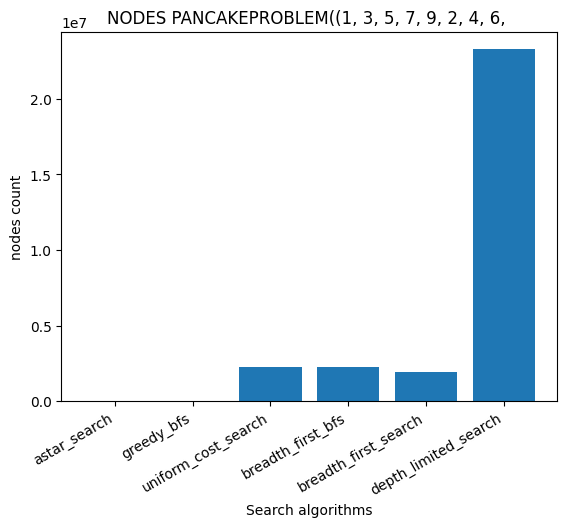

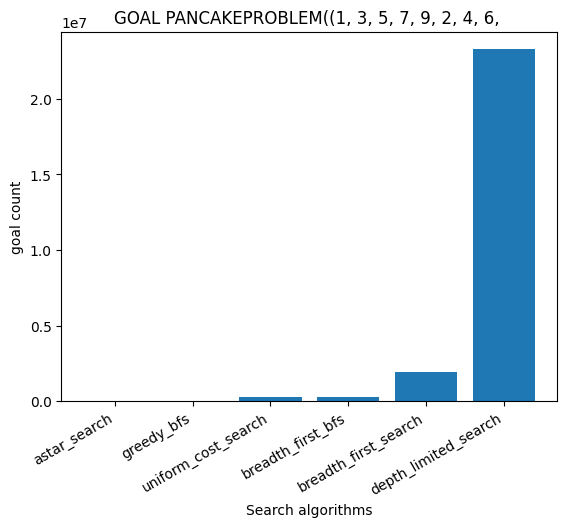

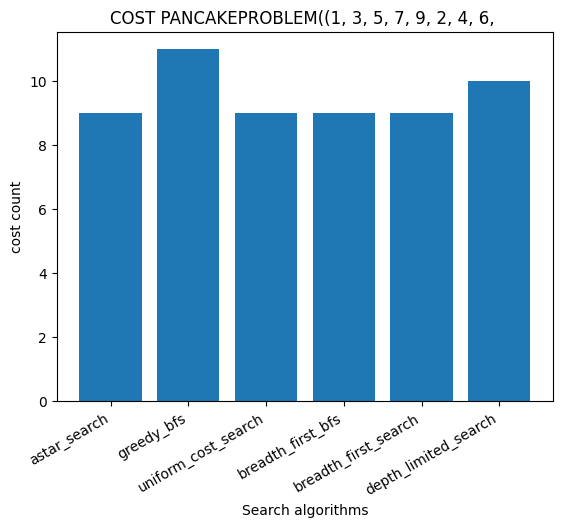

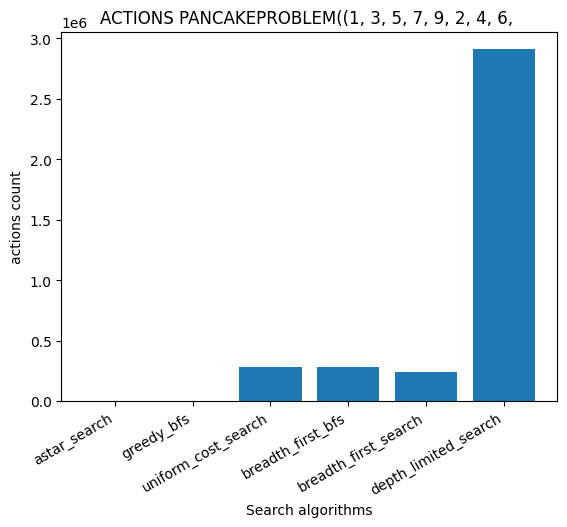

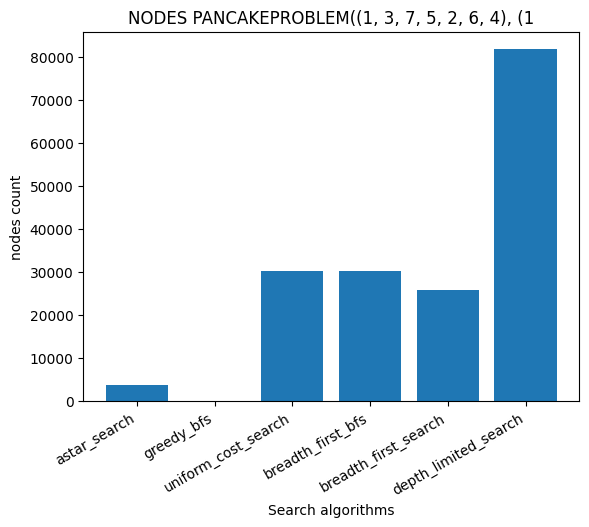

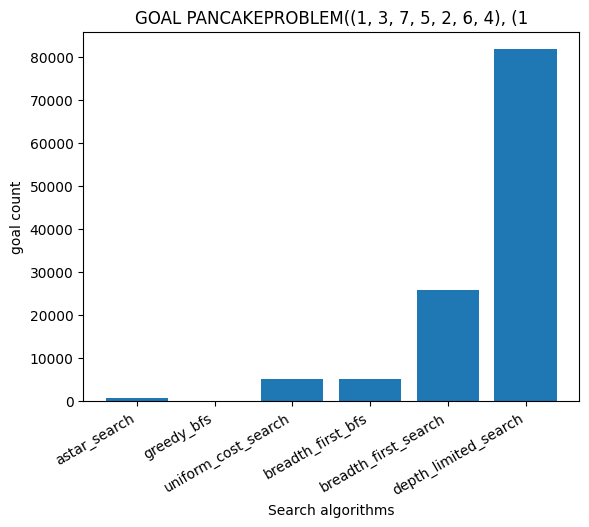

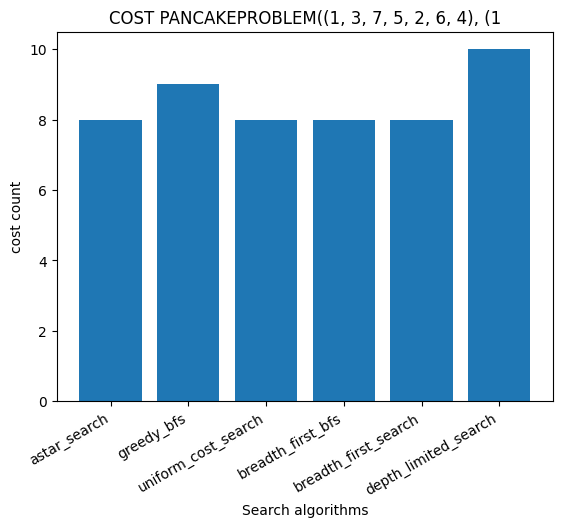

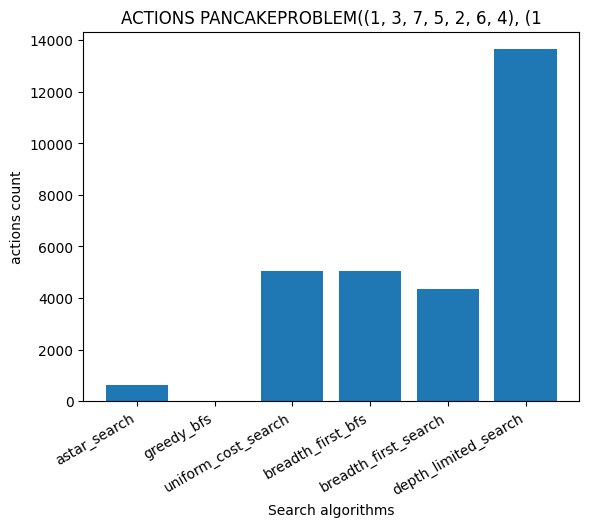

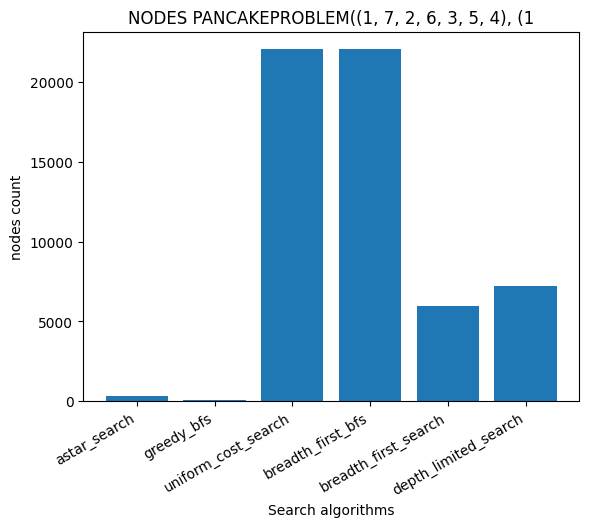

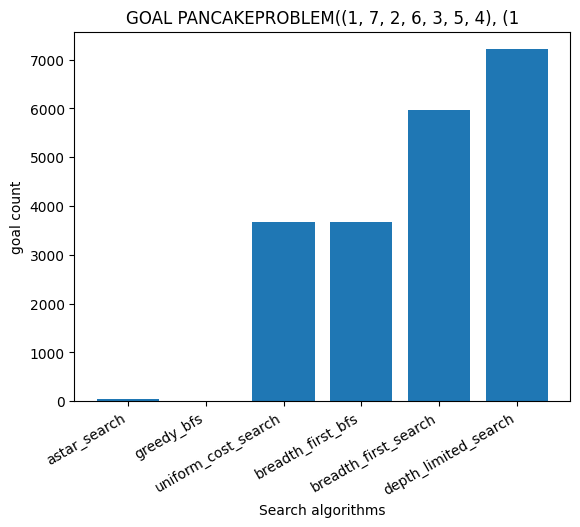

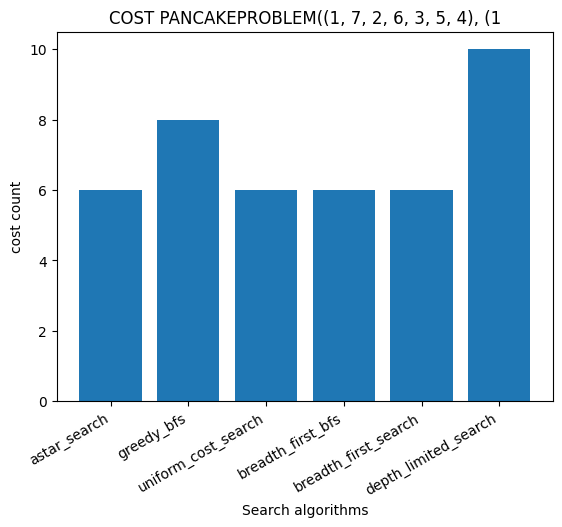

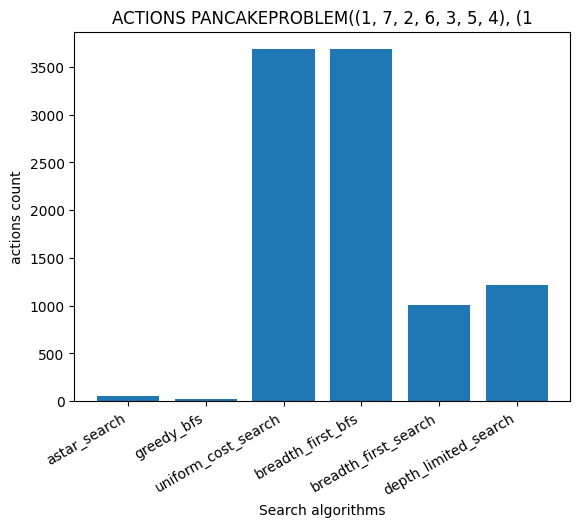

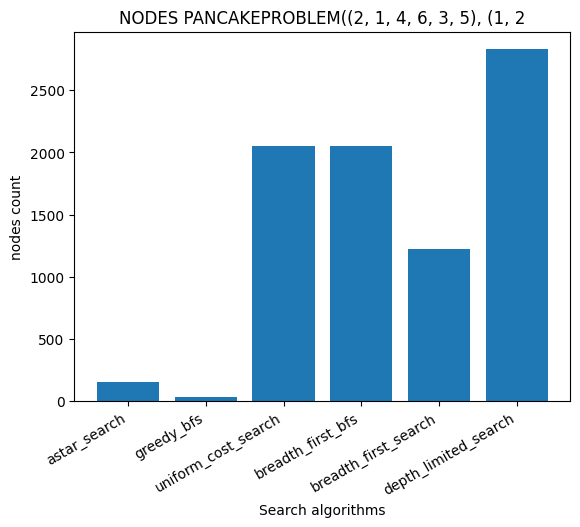

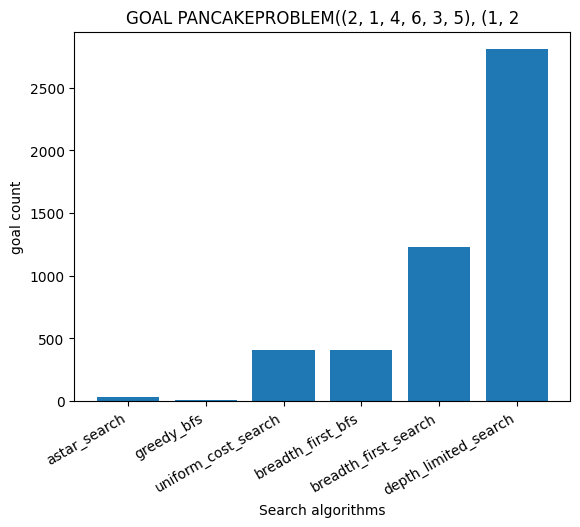

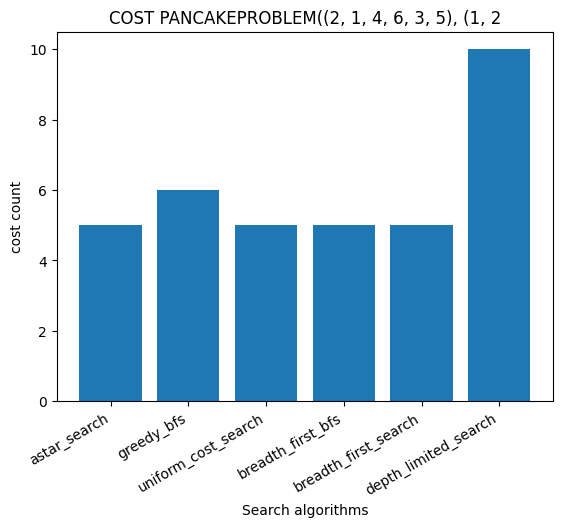

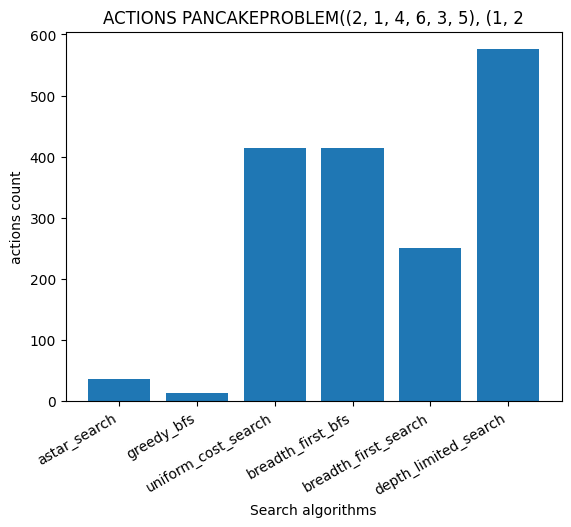

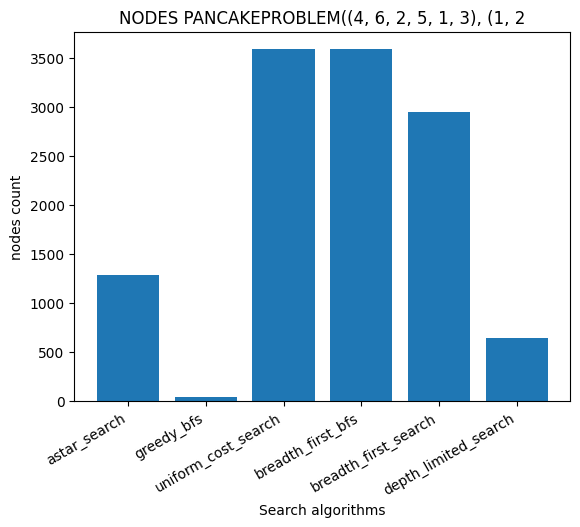

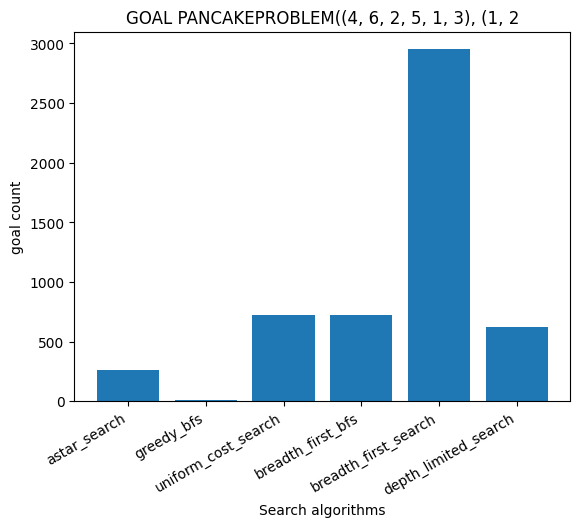

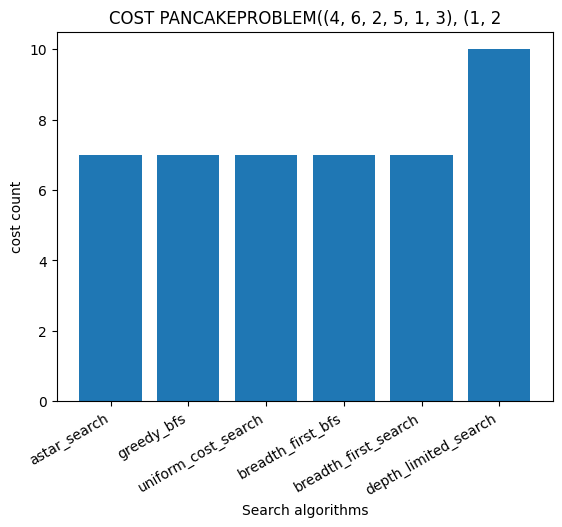

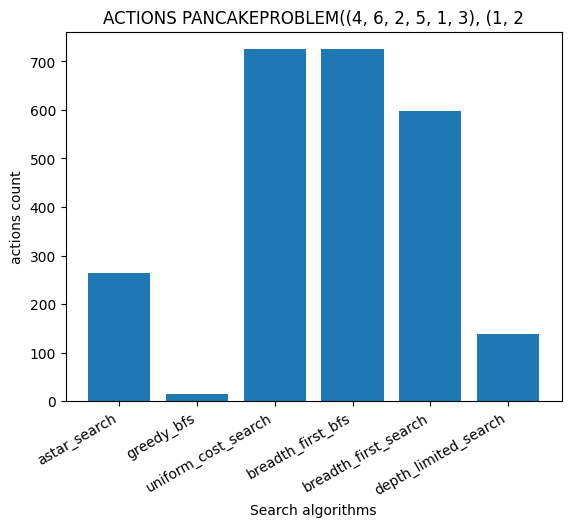

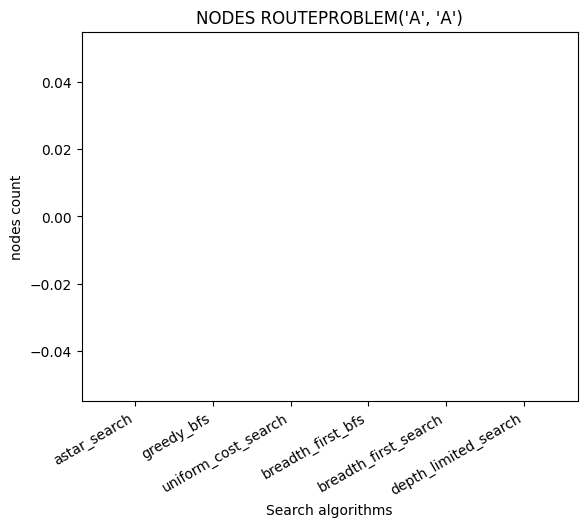

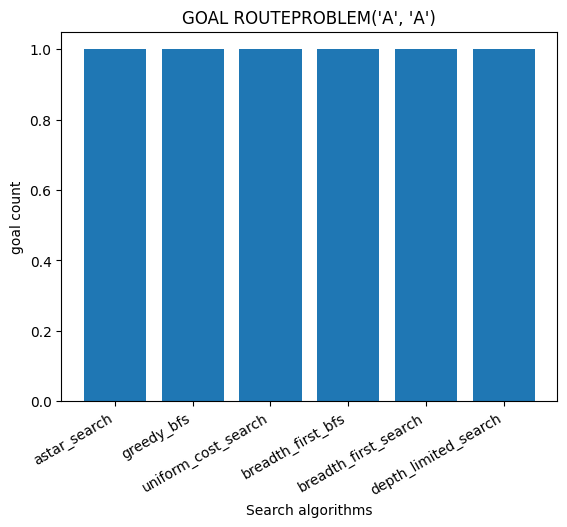

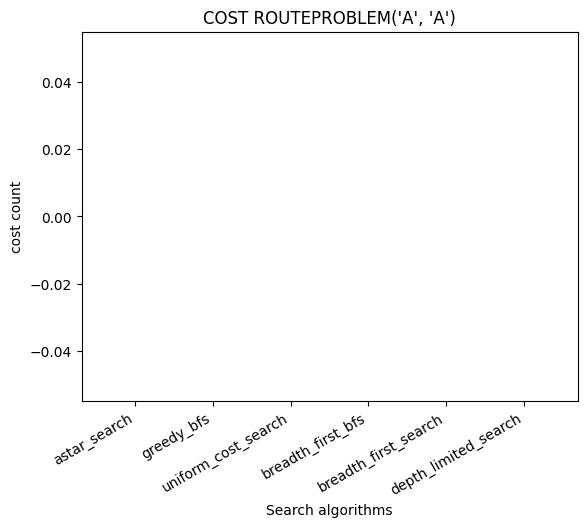

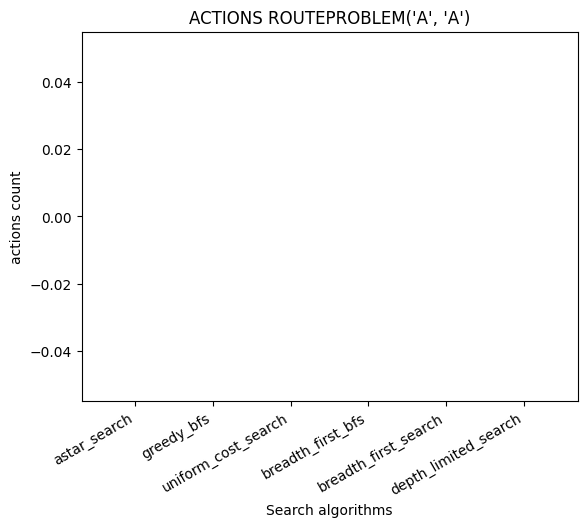

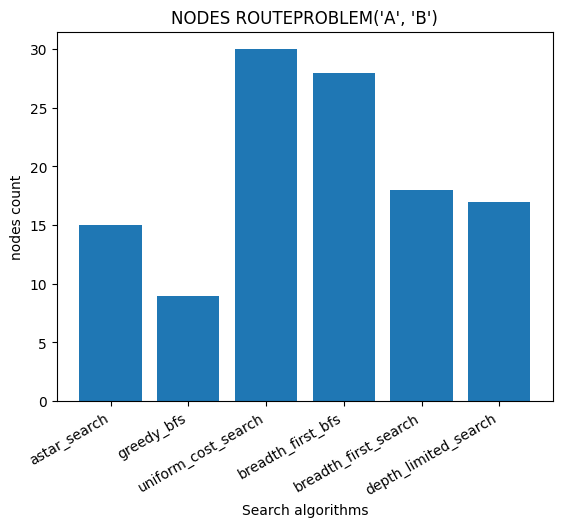

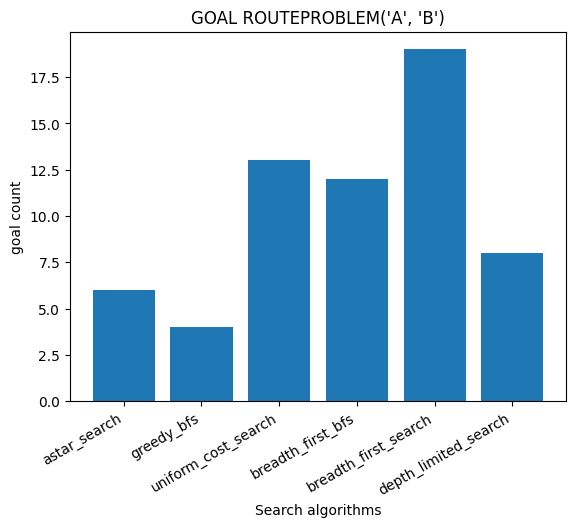

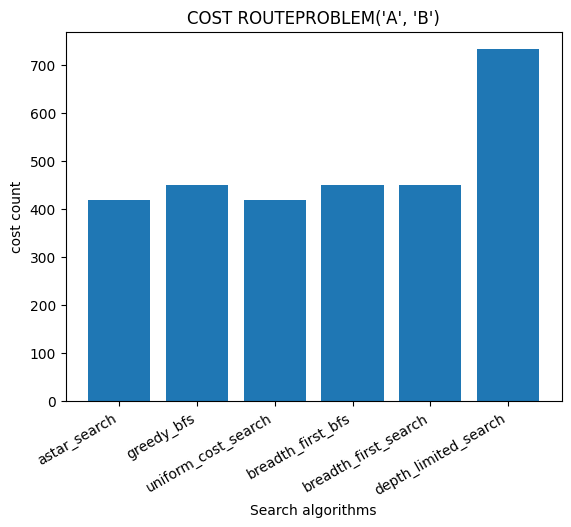

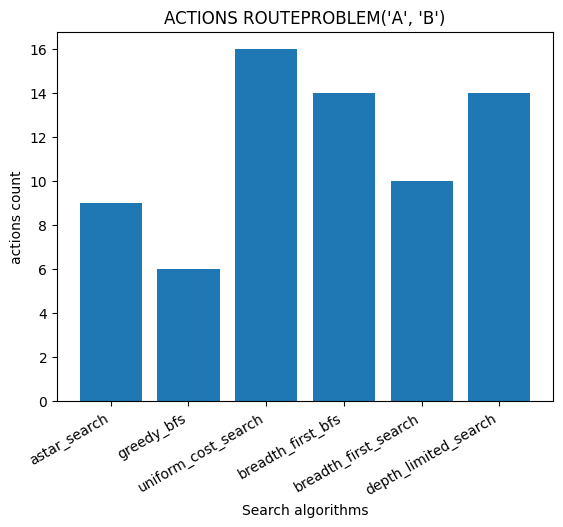

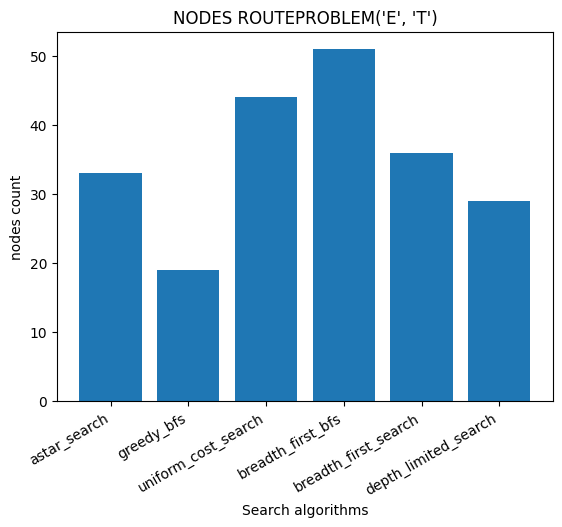

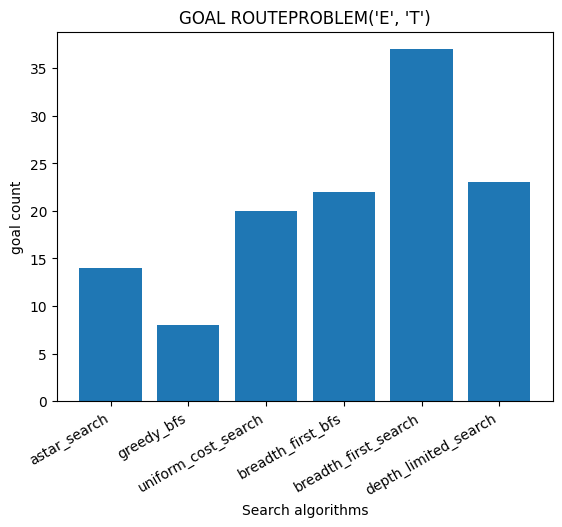

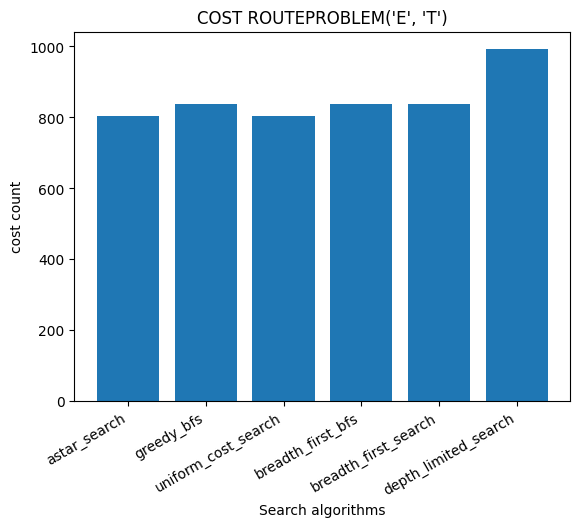

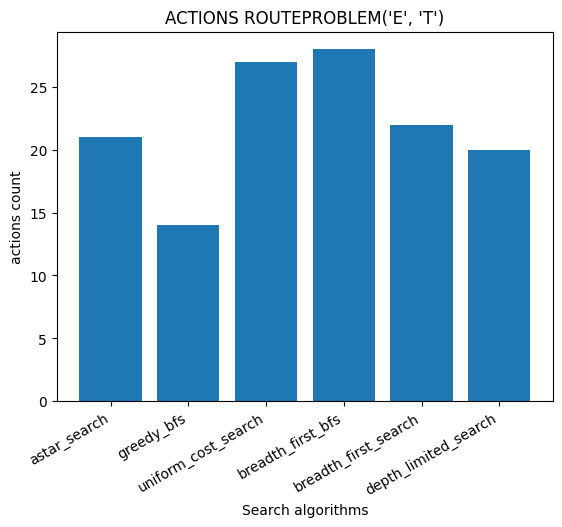

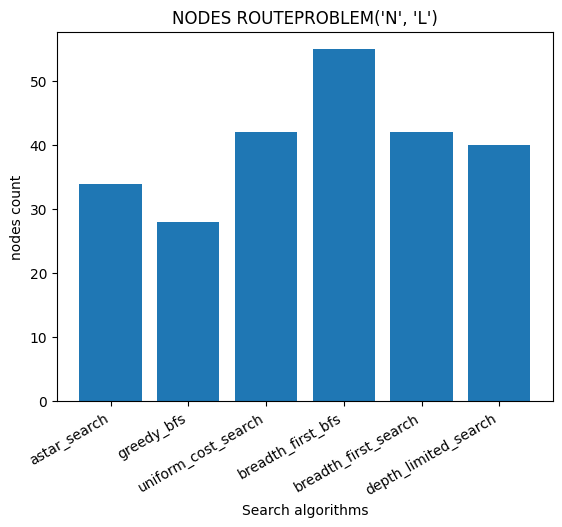

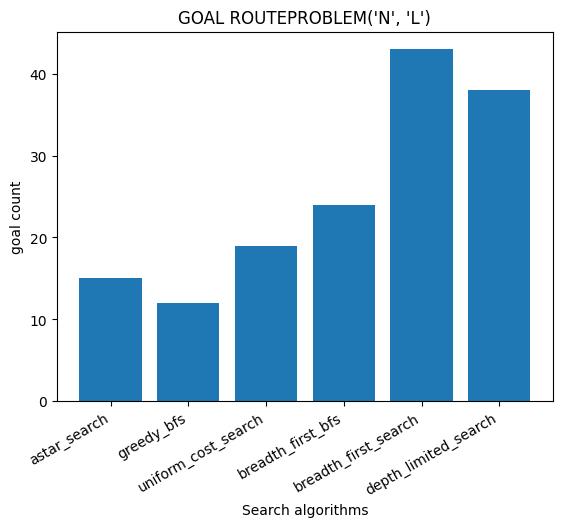

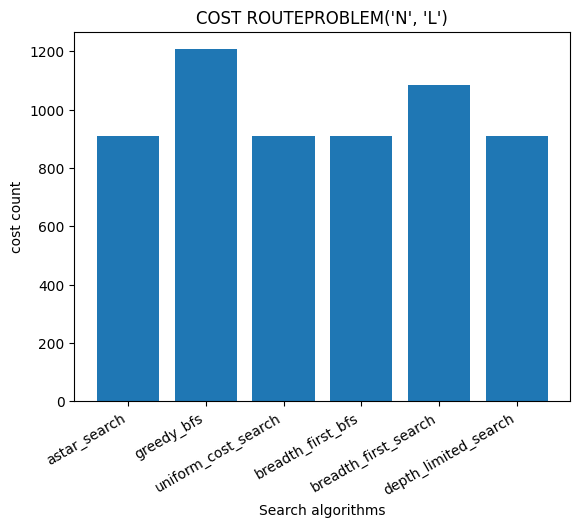

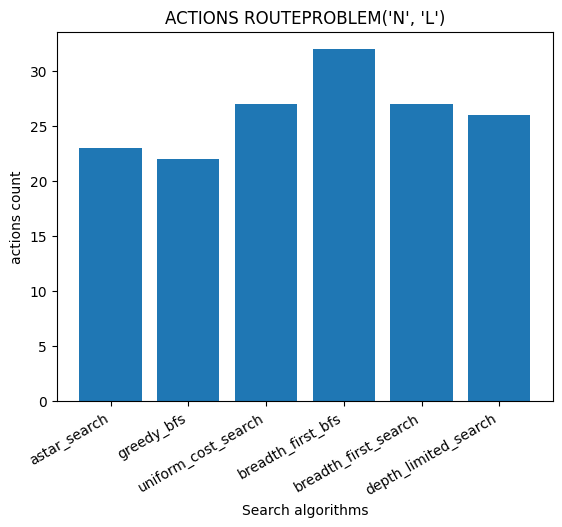

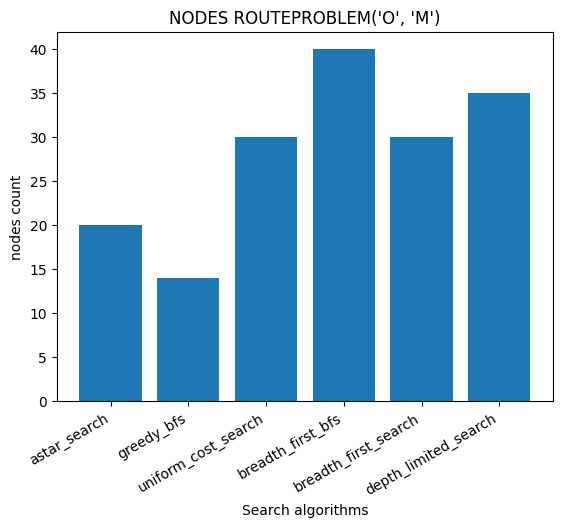

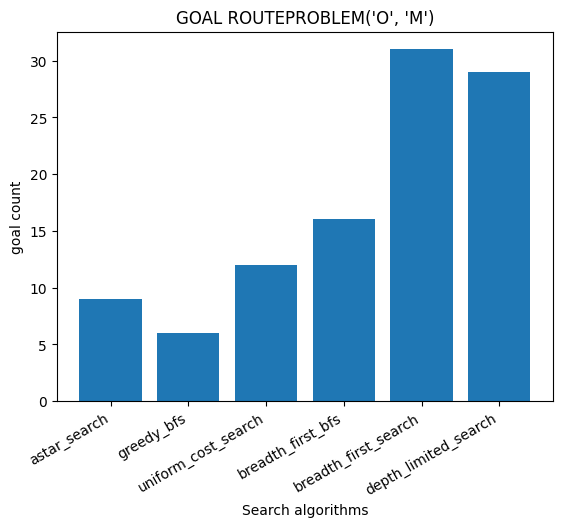

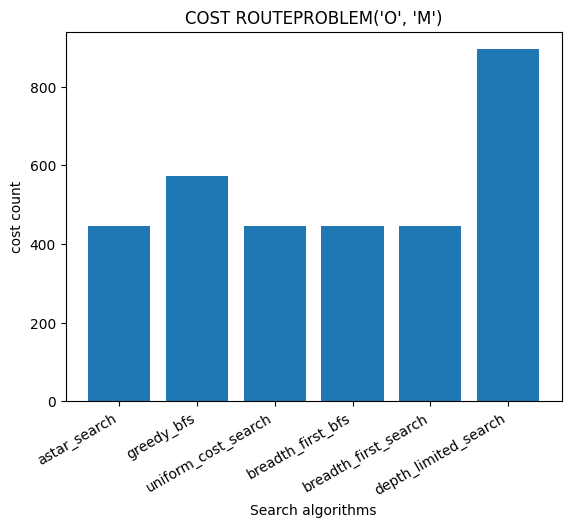

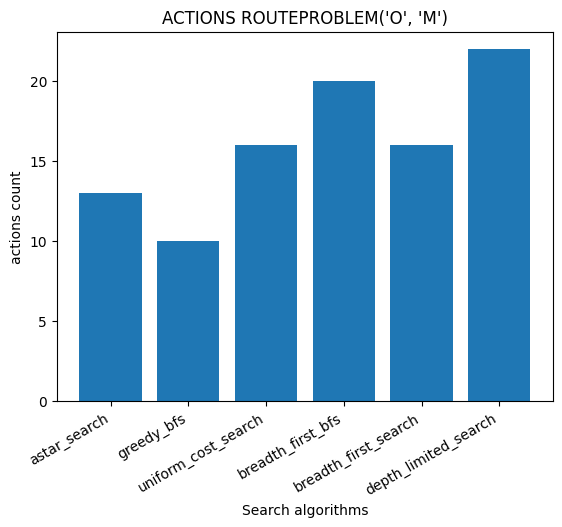

In [ ]:
import matplotlib.pyplot as plt


# function to plot data

def plot_data(data, labels, metric, problem):
  fig = plt.figure()
  x_pos = np.arange(len(labels))
  plt.bar(x_pos, data)
  plt.title(metric.upper() + ' ' + problem.upper())
  plt.xlabel('Search algorithms')
  plt.ylabel( metric + ' count')
  plt.xticks(x_pos, labels, rotation=30, ha='right')
  plt.show()

# let's divide the data per problem
unique_problems = np.unique(problems_labels)

get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

for i in range(len(unique_problems)):
  indexes = get_indexes(unique_problems[i],problems_labels)
  current_searchers_labels = searchers_labels[indexes]
  current_nodes = nodes[indexes]
  current_goal = goal[indexes]
  current_cost = cost[indexes]
  current_actions = actions[indexes]

  # plot the data
  plot_data(current_nodes, current_searchers_labels, 'nodes', unique_problems[i])
  plot_data(current_goal, current_searchers_labels, 'goal', unique_problems[i])
  plot_data(current_cost, current_searchers_labels, 'cost', unique_problems[i])
  plot_data(current_actions, current_searchers_labels, 'actions', unique_problems[i])